# **Download remote sensing data using Google Earth Engine API**

Info about Earth Engine Data Catalogue here https://developers.google.com/earth-engine/datasets

# import necessary libraries

---



In [1]:
!pip -q install geemap

In [2]:
!pip install gcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gcloud: filename=gcloud-0.18.3-py3-none-any.whl size=602926 sha256=d883488111fd56150a42edad7d0001b24de9c7c6af9362eea2d47d93dc41e3d2
  Stored in directory: /root/.cache/pip/wheels/7c/30/88/5017af921da3a33af785f0d0fd3e944b845bc62a445a2c2f69
Successfully built gcloud


In [3]:
import matplotlib.pyplot as plt

In [4]:
!pip -q install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.7 MB/s eta 0:00:00


In [5]:
!pip install earthengine-api requests

In [6]:
import numpy as np

In [7]:
import ee
import glob
import os
import geemap.foliumap as emap
import requests

In [8]:
import rasterio

In [9]:
import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)

In [10]:
from pyproj import Geod

This notebook download data with the Google Earth Engine API, you need to create your credential for it. Find all the info from here: https://earthengine.google.com/

In [11]:
ee.Authenticate()

ee.Initialize(project="ee-lorenzananni")

Mount the Drive and define the directory for the data download

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
path='./EarthEngineExampleData'
os.mkdir(path)

# Example on how to download satellite data for a single location (given the central position) with MODIS

In [12]:
def calculate_square_corners(pointlat, pointlong, pad=0.13456632):
  """
  calculate the corners of the rectangular area surrounding the given position.
  The area is defined by the padding and the location given (lat, long)

  returns:
  toplat(float), toplong (float), botlat (float), botlong (float)
  """
  toplat = pointlat + pad
  toplong = pointlong + pad
  botlat = pointlat - pad
  botlong = pointlong - pad
  return toplat, toplong, botlat, botlong


In [13]:
pointlong, pointlat = 30, 31 # centre of the location we consider
toplat, toplong, botlat, botlong = calculate_square_corners(pointlat, pointlong, pad = 4)

Download MODIS product

Info on all the MODIS products can be found here https://developers.google.com/earth-engine/datasets/catalog/modis

In [14]:
# Load the MODIS dataset
modis = ee.ImageCollection('MODIS/061/MOD09CMG') \
            .filterDate('2023-07-01', '2023-07-31') \
            .first()

# Select the Red, Green, and Blue bands
modis_rgb = modis.select(['Coarse_Resolution_Surface_Reflectance_Band_1', 'Coarse_Resolution_Surface_Reflectance_Band_4', 'Coarse_Resolution_Surface_Reflectance_Band_3'])


In [15]:
region_on_interest = [toplat, toplong, botlat, botlong]

roi =  ee.Geometry.Rectangle(region_on_interest)

# Get the download URL
url = modis_rgb.getDownloadURL({
    'scale': 1000,
    'region': roi,
    'format': 'GEO_TIFF'
})

In [16]:
response = requests.get(url)


In [20]:
file_path = path + "/modis_" +str(toplat) +"-"+str(toplong) +'.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)

print('Download complete.')

# Read the GeoTIFF file using rasterio
with rasterio.open(file_path) as src:
    modis_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands

modis_image_r = np.dstack([modis_image[0], modis_image[1], modis_image[2]])

# Plot the image using matplotlib


Download complete.


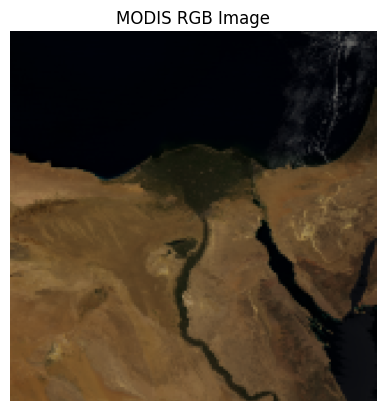

In [21]:
plt.imshow(modis_image_r)
plt.title('MODIS RGB Image')
plt.axis('off')
plt.show()

# **Download data for a location (defined as an area) from SENTINEL**

In [22]:
# Initialize the Earth Engine API
ee.Initialize()

# Define a region of interest (ROI) as a polygon (e.g., in latitude and longitude)
roi = ee.Geometry.Polygon([[
    [11.331180, 44.470309],  # Coordinate of one corner
    [11.229558, 44.549367],
    [11.421254, 44.541137],
    [11.428183, 44.470309]
]])


In [23]:

# Define the Sentinel-2 image collection and filter by date and region
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2021-09-01', '2023-09-30') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter images with less than 10% cloud cover

# Get the first image from the collection
image = collection.first()

# Select the desired bands (e.g., B4: Red, B3: Green, B2: Blue for RGB)
image_rgb = image.select(['B4', 'B3', 'B2'])

In [24]:
image

In [25]:
# Export the image to Google Drive or as a URL
url = image_rgb.getDownloadURL({
    'scale': 10,           # Set the resolution (in meters)
    'region': roi,         # Region of interest to download
    'format': 'GEO_TIFF'
})

# Print the URL for downloading
print(f"Download link: {url}")

Download link: https://earthengine.googleapis.com/v1/projects/ee-lorenzananni/thumbnails/42fda92c135144149efab02dca09addd-39542c7403150b8fe2d5f999075ace5e:getPixels


In [26]:
response = requests.get(url)


file_path = path + '/sentinel.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)

In [27]:
# Read the GeoTIFF file using rasterio
with rasterio.open(file_path) as src:
    sentinel_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands

In [28]:
sentinel_image_r = np.dstack([sentinel_image[0], sentinel_image[1], sentinel_image[2]])


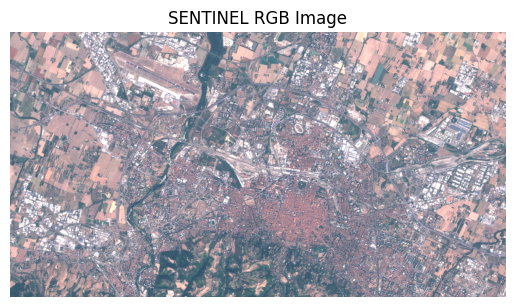

In [29]:
plt.imshow(sentinel_image_r/2000)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

#**Download collection of LandSat data**

Create Class to download LandSat data with Google Earth Engine API



In [30]:
class EarthEngineDownloader:
  """
  Initialize the EarthEngineDownloader class.

  Args:
  product
  bands
  path
  MAX_CLOUD_COVER

  Methods:

  download:
  obtain_collection:
  download_collection:

  """
    # attributes of the class
  def __init__(self, product, bands, path, MAX_CLOUD_COVER=10):
    self.product = product
    self.bands = bands
    self.path = path
    self.MAX_CLOUD_COVER = MAX_CLOUD_COVER

  # methods of the class

  def download(self, toplat, toplong, botlat, botlong, months, start_year, end_year):
    """
      Defines the time, spatial region, and resolution of the satellite data to
      download and calls the ``download_collection`` function. The spatial region
      is defined as Geometry using lat, lon coordinates for the minimum and maximum
      corners of the rectangle


      Args:
      toplat (float): latitude of the top left corner of the rectangle
      toplong (float): longitude of the top left corner of the rectangle
      botlat (float): latitude of the bottom right corner of the rectangle
      botlong (float): longitude of the bottom right corner of the rectangle
      start_year (int): first year to consider for dowloading the data
      end_year (int): final year to consider for dowloading the data


    """
    region_on_interest = [toplat, toplong, botlat, botlong]

    self.region =  ee.Geometry.Rectangle(region_on_interest)


    # Defines the desired pixel scale for each image, have set to the native
    # resolution of each satellite.
    # This is for the Landsat
    self.scale_dict = {
            'LS': 30
        }

    years = [str(i) for i in range(start_year,end_year)]

    date_list = [f"{year}-{month}-01" for year in years for month in months]
    date_list.append("2019-01-01")

    dates = [
            (date_list[i], date_list[i+1]) for i in range(len(date_list)-1)
        ]

        # calling self.download_collection
    for start_date, end_date in dates:
      self.download_collection(
              start_date, end_date
            )


  def obtain_collection(self, start_date, end_date):
    """
      Returns all image collections in the time and region requested,
      filtered for the cloud coverage (MAX_CLOUD_COVERAGE attribute).


      Args:
      start_date (str): starting date for dowloading the data
      end_date (str): end date for dowloading the data

      Returns:
      image_collections (dict): collection of images to download


    """

    start_date = ee.Date(start_date)


    end_date = ee.Date(end_date).advance(-1, "day")

      # Filter input collections by desired date range, region and max cloud
      # coverage.
    criteria  = ee.Filter.And(
            ee.Filter.geometry(self.region),
            ee.Filter.date(start_date, end_date)
        )

    LS = ee.ImageCollection(self.product) \
                          .filter(criteria) \
                          .filter(
                              ee.Filter.lt('CLOUD_COVER', self.MAX_CLOUD_COVER)
                              ) \
                          .select(self.bands)

    image_collections = {
            'LS': LS,
            }

    return image_collections


  def download_collection(self, start_date, end_date, overwrite=False,):
    """
      Obtains all image collections defined in the request function (``obtain_collection``),
      creates a subfolder in the base directory for the starting date, creates
      additional subfolders for each image collection

      Args:
      start_date (str): starting date for dowloading the data
      end_date (str): end date for dowloading the data
    """
        # Obtains all image collections defined in the request function for the
        # chosen test district and date range, with maximum n% cloud cover.
    image_collections = self.obtain_collection(start_date, end_date,)


            # Creates a subfolder in the base directory for the start date
    out_dir = f'{self.path}/{start_date}'
    if not os.path.isdir(out_dir):
      os.mkdir(out_dir)

            # Iterating through each image collection.
    for collection_name, collection in image_collections.items():
      print(collection_name)
                # Counts the number of images in a collection.
      collection_size = collection.size().getInfo()

                # Skips the image collection if it contains no images.
      if collection_size == 0:
        print('No images in collection, skipping.')
        continue

                # Creates additional subfolders for each image collection.
      collection_dir = f'{out_dir}/{collection_name}'
      if not os.path.isdir(collection_dir):
        os.mkdir(collection_dir)

                # Counts number of .tif files already in image collection subfolder.
      tif_count = len(glob.glob1(collection_dir,"*.tif"))

                # Assumes the download for this collection is already complete and
                # therefore skips, provided the number of .tif files already in
                # chosen directory matches the number of images in the collection
                # and overwrite is set to False.
      if collection_size == tif_count and overwrite == False:
        print('Correct number of .tif files for image collection already in directory, skipping.')
        continue

                # Exports each image in the filtered image collection to
                # geoTIFF format.
    emap.ee_export_image_collection(
                    collection,
                    collection_dir,
                    crs='EPSG:4326',
                    scale=self.scale_dict[collection_name],
                    region=self.region
                )

Function to handle bitmask



In [31]:
def mask_from_bitmask(bitmask, mask_type):
    '''
    Converts an earth engine QA bitmask to a boolean array of ``mask_type`` pixels.
    Bitmask array conversion from https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

    Args:
        bitmask (np.ndarray): ``shape(pix_x, pix_y)``
        mask_type (str): String specifying kind of mask to return. Can be ``water``, ``cloud``, or ``shadow``.

    Returns:
        Boolean mask with shape ``shape(pix_x, pix_y)`` indicating pixels of ``mask_type.
    '''

    idx_dict = {
        "goodquality" : 0,
        "water" : 8,
        "cloud" : 12,
        "shadow" : 11,
    }

    # number of bits to convert bitmask to
    m = 16
    # Function to convert an integer to a string binary representation
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    # Calculte binary representations
    strs = to_str_func(bitmask)
    # Create empty array for the bitmask
    bitmask_bits = np.zeros(list(bitmask.shape) + [m], dtype=np.int8)
    # Iterate over all m  bits
    for bit_ix in range(0, m):
        # Get the bits
      fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        # Store the bits
      bitmask_bits[:, :, bit_ix] = fetch_bit_func(strs).astype("int8")

    # The bitmask is stored in bit 7 (index 15-7=8).
    bool_bitmask = bitmask_bits[:, :, idx_dict[mask_type]] == 1

    return bool_bitmask

Create Class to download Google Earth Engine product LANDSAT RAW and SR

In [32]:
class DownloadSatelliteData:
    '''
    A class to make training data for the water mask and the depth of the sea.
    For info on SR bands https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1574_L8_Data_Users_Handbook-v5.0.pdf
    pag 18 of this handbook
    For info on QA pixel pag. 61 of the handbook
    '''
    def __init__(
        self,
        path,
        toplat,
        toplong,
        botlat,
        botlong,
        start_year,
        end_year,
        months = ["01", "04"],
        SR_PROD='LANDSAT/LC08/C02/T1_L2',
        RAW_PROD='LANDSAT/LC08/C02/T1',
        SR_BANDS=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL'],
        RAW_BANDS=['B2', 'B3', 'B4', 'B5', 'B6', 'B7'],
        MAX_CLOUD_COVER=10,
        ):
        '''Initialize the MakeTrainingData_WaterDepth class.

        Args:
        - path (str): Path to the directory where the data will be stored.
        - toplat (float): Latitude of the top left corner of the region of interest.
        - toplong (float): Longitude of the top left corner of the region of interest.
        - botlat (float): Latitude of the bottom right corner of the region of interest.
        - botlong (float): Longitude of the bottom right corner of the region of interest.
        - start_year (int): Starting year for the Landsat imagery.
        - end_year (int): Ending year for the Landsat imagery.
        - SR_PROD (str, optional): Landsat surface reflectance product.
                                   Defaults to 'LANDSAT/LC08/C02/T1_L2'.
        - RAW_PROD (str, optional): Landsat raw product.
                                    Defaults to 'LANDSAT/LC08/C02/T1'.
        - SR_BANDS (list, optional): Bands to select from the surface reflectance product.
                                     Defaults to ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'QA_PIXEL'].
        - RAW_BANDS (list, optional): Bands to select from the raw product.
                                      Defaults to ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'].
        - MAX_CLOUD_COVER (int, optional): Maximum cloud cover percentage. Defaults to 10.
        '''

        # Set up region of interest
        region_of_interest = [toplat, toplong, botlat, botlong]
        self.region =  ee.Geometry.Rectangle(region_of_interest)

        # Set up other params
        self.SR_PROD = SR_PROD
        self.RAW_PROD = RAW_PROD
        self.SR_BANDS = SR_BANDS
        self.RAW_BANDS = RAW_BANDS
        self.MAX_CLOUD_COVER = MAX_CLOUD_COVER
        self.SR_PATH = path + '/SR'
        self.RAW_PATH = path + '/RAW'

        # Make paths if not present
        if not os.path.isdir(self.SR_PATH):
            os.mkdir(self.SR_PATH)
        if not os.path.isdir(self.RAW_PATH):
            os.mkdir(self.RAW_PATH)


        # Make date list
        years = [str(i) for i in range(start_year,end_year)]
        date_list = [f"{year}-{month}-01" for year in years for month in months]
        date_list.append("2019-01-01")
        self.dates = [(date_list[i], date_list[i+1]) for i in range(len(date_list)-1)]

    def download_data(self):
        '''Download the imagery data for the specified region of interest and time range.'''
        # Define max water count and best file
        qa_pixel_max = 0
        self.best_file = ''

        # Iterate through the months
        for start_date, end_date in self.dates:

            # Define paths for each month
            SR_OUT_PATH = f'{self.SR_PATH}/{start_date}'
            if not os.path.isdir(SR_OUT_PATH):
                os.mkdir(SR_OUT_PATH)

            RAW_OUT_PATH = f'{self.RAW_PATH}/{start_date}'
            if not os.path.isdir(RAW_OUT_PATH):
                os.mkdir(RAW_OUT_PATH)


            # Convert the dates to a form earth engine likes
            start_date = ee.Date(start_date)
            end_date = ee.Date(end_date).advance(-1, "day")

            # Filter input collections by desired date range, region and cloud coverage.
            criteria  = ee.Filter.And(
                ee.Filter.geometry(self.region),
                ee.Filter.date(start_date, end_date)
            )

            # Get the surface reflectance collection
            SR = ee.ImageCollection(self.SR_PROD) \
                            .filter(criteria) \
                            .filter(ee.Filter.lt('CLOUD_COVER', self.MAX_CLOUD_COVER)) \
                            .select(self.SR_BANDS)

            # Get the RAW collection
            RAW = ee.ImageCollection(self.RAW_PROD) \
                .filter(criteria) \
                .filter(ee.Filter.lt('CLOUD_COVER', self.MAX_CLOUD_COVER)) \
                .select(self.RAW_BANDS)

            # Export the surface reflectance collection to the SR_OUT_PATH directory
            emap.ee_export_image_collection(
                    SR,
                    SR_OUT_PATH,
                    crs='EPSG:4326',
                    scale=30,
                    region=self.region
                )

            # Export the RAW collection to the RAW_OUT_PATH directory
            emap.ee_export_image_collection(
                    RAW,
                    RAW_OUT_PATH,
                    crs='EPSG:4326',
                    scale=30,
                    region=self.region
                )
  # Here the best file is selected as the file with the highest number of QA

            # Loop through the files in the surface reflectance folder
            for file in glob.glob(SR_OUT_PATH+'/*'):
                # Open the file
                reader = rasterio.open(file)
                # Get the QA pixels
                qa_pix = reader.read(5)
                # Get the quality mask
                qa_mask = mask_from_bitmask(qa_pix, 'goodquality')
                # Is the number of water pixels bigger than the current max?
                if qa_pixel_max < qa_mask.sum():
                    # If so, update the water max and the best file
                    qa_pixel_max = qa_mask.sum()
                    self.best_file = file



Define the region and time of interest

Download a collection of images (RAW and SR) from LandSat for Portsmouth in April 2013 and 2014

In [33]:
start_year = 2013
end_year= 2014

In [34]:
download = DownloadSatelliteData(
    path,
    toplat,
    toplong,
    botlat,
    botlong,
    start_year,
    end_year,
    months=["04"]
)

In [ ]:
download.download_data()

Total number of images: 3654

Exporting 1/3654: ./EarthEngineExampleData/SR/2013-04-01/LC08_173040_20160502.tif
Generating URL ...
An error occurred while downloading.
Total request size (13326193830 bytes) must be less than or equal to 50331648 bytes.


Exporting 2/3654: ./EarthEngineExampleData/SR/2013-04-01/LC08_173041_20130424.tif
Generating URL ...
An error occurred while downloading.
Total request size (13326193830 bytes) must be less than or equal to 50331648 bytes.


Exporting 3/3654: ./EarthEngineExampleData/SR/2013-04-01/LC08_173041_20130526.tif
Generating URL ...
An error occurred while downloading.
Total request size (13326193830 bytes) must be less than or equal to 50331648 bytes.


Exporting 4/3654: ./EarthEngineExampleData/SR/2013-04-01/LC08_173041_20130611.tif
Generating URL ...
An error occurred while downloading.
Total request size (13326193830 bytes) must be less than or equal to 50331648 bytes.


Exporting 5/3654: ./EarthEngineExampleData/SR/2013-04-01/LC08_173041_2